In [ ]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import fsolve, least_squares
from contextlib import contextmanager
from io import StringIO

sys.path.append('/path/to/EquiNet') # location of EquiNet repository

from chemprop.train import make_predictions
from chemprop.args import PredictArgs

In [62]:
# set your inputs
smiles1 = "CCO"
smiles2 = "O"
P_target = 101325  # Pressure in Pa
n = 101 # Mesh size of mole fractions

In [63]:
# If you want a temporary path location for the results to write to
import tempfile

temp_preds = tempfile.mktemp(suffix='.csv')
temp_features = tempfile.mktemp(suffix='.csv')
temp_test = tempfile.mktemp(suffix='.csv')
model_folder = "."

In [64]:
# context class to suppress print statements from repeated model predictions

class NoPrint:
    """
    Context manager to suppress print statements.
    """
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_sterr = sys.stderr
        sys.stdout = StringIO()
        sys.stderr = StringIO()

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self._original_stdout
        sys.stderr = self._original_sterr


In [65]:
# Finding the pure component vapor pressures over a range of temperatures

logP_target = np.log10(P_target)
print("logP_target", logP_target)

# make input files
x1s = np.full(701, 0.5)
x2s = np.full(701, 0.5)
Ts = np.linspace(100, 800, 701)

test_df = pd.DataFrame({
    'smiles1': [smiles1] * 701,
    'smiles2': [smiles2] * 701,
})
features_df = pd.DataFrame({
    'x1': x1s,
    'x2': x2s,
    'T': Ts,
    'log10P1sat': ["nan"] * 701,
    'log10P2sat': ["nan"] * 701,
})

test_df.to_csv(temp_test, index=False)
features_df.to_csv(temp_features, index=False)

# make predictions

arguments = [
    '--test_path', temp_test,
    '--features_path', temp_features,
    '--preds_path', temp_preds,
    '--checkpoint_dir', model_folder,
    '--number_of_molecules', '2',
    '--num_workers', '0',
]

args = PredictArgs().parse_args(arguments)

with NoPrint():
    preds = np.array(make_predictions(args=args)) # output: [y1,y2,log10P,lngamma1,lngamma2,log10P1sat,log10P2sat]

logP_target 5.005716612413731


In [66]:
# Finding T closest to the target pressure for each component
logP1sats = preds[:, 5]
logP2sats = preds[:, 6]

closest_P1_index = np.argmin(np.abs(logP1sats - logP_target))
closest_P2_index = np.argmin(np.abs(logP2sats - logP_target))

closest_P1_T = Ts[closest_P1_index]
closest_P2_T = Ts[closest_P2_index]

print("closest P1", logP1sats[closest_P1_index], "at T =", closest_P1_T)
print("closest P2", logP2sats[closest_P2_index], "at T =", closest_P2_T)


closest P1 4.9991631507873535 at T = 351.0
closest P2 5.006927967071533 at T = 373.0


In [67]:
# Set up a prediction function to optimize around
counter = 1

def predict_P(T):
    global counter
    global preds

    print(f"iteration {counter}")
    counter += 1
    print("predict_P called with T =", T)
    
    test_df = pd.DataFrame({
        'smiles1': [smiles1]*n,
        'smiles2': [smiles2]*n,
    })
    features_df = pd.DataFrame({
        'x1': np.linspace(0, 1, n),
        'x2': np.linspace(1, 0, n),
        'T': T, # T is a list of temperatures 
        'log10P1sat': ["nan"]*n,
        'log10P2sat': ["nan"]*n,
    })
    test_df.to_csv(temp_test, index=False)
    features_df.to_csv(temp_features, index=False)

    args = PredictArgs().parse_args([
        '--test_path', temp_test,
        '--features_path', temp_features,
        '--preds_path', temp_preds,
        '--checkpoint_dir', model_folder,
        '--number_of_molecules', '2',
        '--num_workers', '0',
    ])

    with NoPrint():
        preds = np.array(make_predictions(args=args))  # [y1,y2,log10P,lngamma1,lngamma2,log10P1sat,log10P2sat]
        P_preds = 10 ** preds[:, 2]
    print("preds", P_preds)
    return P_preds - P_target

In [68]:
# Assumes linear interpolation between pure component temperatures
T_guess = np.linspace(closest_P2_T, closest_P1_T, n)
T_guess

array([373.  , 372.78, 372.56, 372.34, 372.12, 371.9 , 371.68, 371.46,
       371.24, 371.02, 370.8 , 370.58, 370.36, 370.14, 369.92, 369.7 ,
       369.48, 369.26, 369.04, 368.82, 368.6 , 368.38, 368.16, 367.94,
       367.72, 367.5 , 367.28, 367.06, 366.84, 366.62, 366.4 , 366.18,
       365.96, 365.74, 365.52, 365.3 , 365.08, 364.86, 364.64, 364.42,
       364.2 , 363.98, 363.76, 363.54, 363.32, 363.1 , 362.88, 362.66,
       362.44, 362.22, 362.  , 361.78, 361.56, 361.34, 361.12, 360.9 ,
       360.68, 360.46, 360.24, 360.02, 359.8 , 359.58, 359.36, 359.14,
       358.92, 358.7 , 358.48, 358.26, 358.04, 357.82, 357.6 , 357.38,
       357.16, 356.94, 356.72, 356.5 , 356.28, 356.06, 355.84, 355.62,
       355.4 , 355.18, 354.96, 354.74, 354.52, 354.3 , 354.08, 353.86,
       353.64, 353.42, 353.2 , 352.98, 352.76, 352.54, 352.32, 352.1 ,
       351.88, 351.66, 351.44, 351.22, 351.  ])

In [69]:
# optimize using scipy. Sparsity indicates that each temperature only affects its own prediction.

T_solution = least_squares(predict_P, T_guess, diff_step=1e-4, jac_sparsity=np.identity(n))

iteration 1
predict_P called with T = [373.   372.78 372.56 372.34 372.12 371.9  371.68 371.46 371.24 371.02
 370.8  370.58 370.36 370.14 369.92 369.7  369.48 369.26 369.04 368.82
 368.6  368.38 368.16 367.94 367.72 367.5  367.28 367.06 366.84 366.62
 366.4  366.18 365.96 365.74 365.52 365.3  365.08 364.86 364.64 364.42
 364.2  363.98 363.76 363.54 363.32 363.1  362.88 362.66 362.44 362.22
 362.   361.78 361.56 361.34 361.12 360.9  360.68 360.46 360.24 360.02
 359.8  359.58 359.36 359.14 358.92 358.7  358.48 358.26 358.04 357.82
 357.6  357.38 357.16 356.94 356.72 356.5  356.28 356.06 355.84 355.62
 355.4  355.18 354.96 354.74 354.52 354.3  354.08 353.86 353.64 353.42
 353.2  352.98 352.76 352.54 352.32 352.1  351.88 351.66 351.44 351.22
 351.  ]
preds [101608.01498614 112306.04108251 121306.41339656 128867.29360725
 135205.78487214 140503.59457178 144929.61255525 148615.56754826
 151675.80526958 154199.91187585 156264.23032265 157938.23552608
 159276.70113141 160330.31998632 161143.19

In [70]:
T = T_solution.x
T

array([372.9212244 , 369.80747037, 367.34046436, 365.34014783,
       363.74010536, 362.44627736, 361.38706739, 360.48848867,
       359.7172853 , 359.05668419, 358.48586724, 357.98704884,
       357.54963897, 357.16260693, 356.8196825 , 356.51455112,
       356.24378285, 356.0006434 , 355.78102941, 355.58181321,
       355.39963102, 355.23335563, 355.07968636, 354.93677445,
       354.80249347, 354.67635779, 354.55743824, 354.44474679,
       354.33736473, 354.2346238 , 354.13589352, 354.04050516,
       353.94803875, 353.85854105, 353.77152277, 353.68659653,
       353.60345544, 353.5218629 , 353.44173086, 353.36297486,
       353.28557024, 353.20949154, 353.13451073, 353.06065988,
       352.98805707, 352.91656607, 352.84628206, 352.77693249,
       352.70850198, 352.64089605, 352.57433705, 352.50888223,
       352.44441799, 352.3810726 , 352.3189347 , 352.25775783,
       352.19769188, 352.13872938, 352.0809529 , 352.02440986,
       351.96917067, 351.9152809 , 351.86277557, 351.81

In [71]:
T_solution.fun # residuals from the target pressure, in Pa

array([ 0.04392657,  0.04392657, -0.06732403,  0.04392657,  0.04392657,
        0.04392657, -0.06732403, -0.06732403,  0.04392657,  0.04392657,
        0.04392657,  0.04392657,  0.04392657,  0.04392657, -0.06732403,
        0.04392657,  0.04392657, -0.06732403, -0.06732403, -0.06732403,
       -0.06732403,  0.04392657,  0.04392657,  0.04392657,  0.04392657,
       -0.06732403,  0.04392657,  0.04392657, -0.06732403, -0.06732403,
       -0.06732403,  0.04392657,  0.04392657, -0.06732403, -0.06732403,
       -0.06732403,  0.04392657, -0.06732403,  0.04392657, -0.06732403,
        0.04392657, -0.06732403,  0.04392657, -0.06732403,  0.04392657,
        0.04392657, -0.06732403,  0.04392657,  0.04392657, -0.06732403,
       -0.06732403,  0.04392657, -0.06732403, -0.06732403,  0.04392657,
        0.04392657, -0.06732403,  0.04392657,  0.04392657,  0.04392657,
       -0.06732403,  0.04392657,  0.04392657,  0.04392657,  0.04392657,
        0.04392657,  0.04392657,  0.04392657,  0.04392657,  0.04

Text(0.5, 1.0, 'Mixture of SMILES CCO (1) and \nSMILES O (2) at P = 101325 Pa')

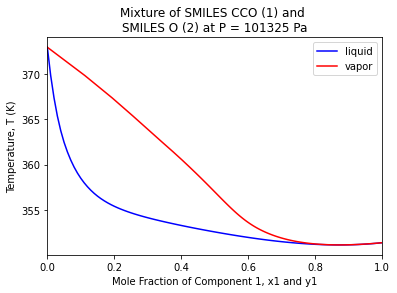

In [74]:
# Recover compositions from the global preds variable
# To avoid use of global variables, re-predict using the optimized temperatures

x1s = np.linspace(0, 1, n)
y1s = preds[:, 0]


plt.plot(x1s, T,label="liquid", color='blue')
plt.plot(y1s, T, label="vapor", color='red')
plt.legend()
plt.xlim(0, 1)
plt.ylabel('Temperature, T (K)')
plt.xlabel('Mole Fraction of Component 1, x1 and y1')
plt.title(f'Mixture of SMILES {smiles1} (1) and \nSMILES {smiles2} (2) at P = {P_target} Pa')